# SunPy Maps: SDO/AIA

In [1]:
import ast
import sunpy.map
import torch

import matplotlib.pyplot as plt

from sdoml import SDOMLDataset
from sdoml.sources import DataSource

from timeit import default_timer as timer

### Instantiate the `SDOMLDataset` class

First, we will instantiate the ``SDOMLDataset`` class, to load one month of the six optically-thin SDO/AIA channels (94, 131, 171, 193, 211, 335 Å) from ``fdl-sdoml-v2/sdomlv2_small.zarr``

In [2]:
data_to_load = {
    "AIA": {
        "root": "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_small.zarr/",
        "channels": ["94A", "131A", "171A", "193A", "211A", "335A"],
    },
}

datasource_arr = [DataSource(instrument=k, meta=v) for k, v in data_to_load.items()]

In [3]:
sdomlds = SDOMLDataset(
    cache_max_size=1 * 512 * 512 * 2048,
    years=[
        "2010",
    ],
    data_to_load=datasource_arr,
)

### Call the torch Dataloader

With the Dataset instantiated, while we could directly access the dataset using the ``__getitem__`` method ( ``sdomlds.__getitem__(idx)`` loads and returns single sample from the dataset at the given index ``idx``), we will use the ``torch.utils.data.DataLoader`` iterator with a ``batch_size`` of 1, and no shuffling of the data.

As will be evident, the first data access for a given chunk is relatively slow (it is retrieved from s3 on Amazon Web Services), however the second data access is faster, as this uses cache. For more information see https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.LRUStoreCache

In [4]:
dataloader = torch.utils.data.DataLoader(
    sdomlds,
    batch_size=1,
    shuffle=False,
)

#### Loading one set of images

In [5]:
data = next(iter(dataloader))

``SDOMLDataset()`` returns both image, and metadata as a single dictionary:

```
In:  data.keys()
Out: dict_keys(['data', 'meta'])
```

* The ``images`` returned by ``__getitem__(idx)`` for a single observations is of size: ``(1, 6, 512, 512)``, where each item contains of the 6 requested co-temporal observations (SDO/AIA ``[94, 131, 171, 193, 211, 335]``) of ``torch.Size([512, 512])``. 

```
In:  data['data'].keys()
Out: dict_keys(['AIA'])
In:  data['data']['AIA'].shape
Out: torch.Size([1, 6, 512, 512])
```

* The ``metadata`` for AIA is a list of ``str(dictionary)``, each with 175 key-value pairs. EVE is stored similarly, with each dictionary containing 3 key-value pairs. As shown below, the length of these data is 64.

```
In:  data['meta'].keys()
Out: dict_keys(['AIA'])
In:  len(data['meta']['AIA'])
Out: 1
```

A small excerpt of the AIA dictionary (for index 0 in the batch of 64) is shown below for ``['DEG_COR', 'EXPTIME', 'WAVELNTH', 'T_OBS']``.


```
> batch_index = 0
> data['data']['AIA'][batch_index].shape
torch.Size([6, 512, 512])

> ast.literal_eval(data['meta']['AIA'][batch_index])

{
    ...
    'DEG_COR': [1.083, 0.950019, 0.99739, 0.99217, 0.982774, 0.901734],
    'EXPTIME': [2.901124, 2.901351, 1.999653, 2.000068, 2.900861, 2.900854],
    'WAVELNTH': [94, 131, 171, 193, 211, 335],
    'T_OBS': ['2010-08-01T00:00:09.57Z',
              '2010-08-01T00:00:11.07Z',
              '2010-08-01T00:00:01.34Z',
              '2010-08-01T00:00:08.84Z',
              '2010-08-01T00:00:02.07Z',
              '2010-08-01T00:00:05.07Z']
    ...
}

```

where a single key can be accessed:

```
In:  ast.literal_eval(data['meta']['AIA'][batch_index])['DEG_COR']
Out: [1.083, 0.950019, 0.99739, 0.99217, 0.982774, 0.901734]
```

## Plotting

For the 211 Å channel, returned from the dataloader, the following code block creates a ``sunpy.map`` from the ``images`` and ``metadata``.

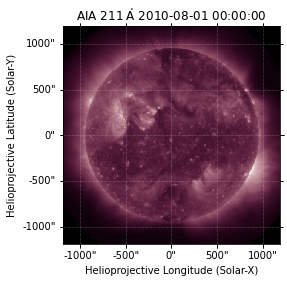

In [6]:
inst_num = 4
selected_image = data["data"]["AIA"][0, inst_num, :, :]
selected_headr = {
    keys: values[inst_num]
    for keys, values in ast.literal_eval(data["meta"]["AIA"][0]).items()
}

sunpy.map.Map(selected_image.numpy(), selected_headr).plot()

Similarly, as above, we can plot all of the loaded AIA channels

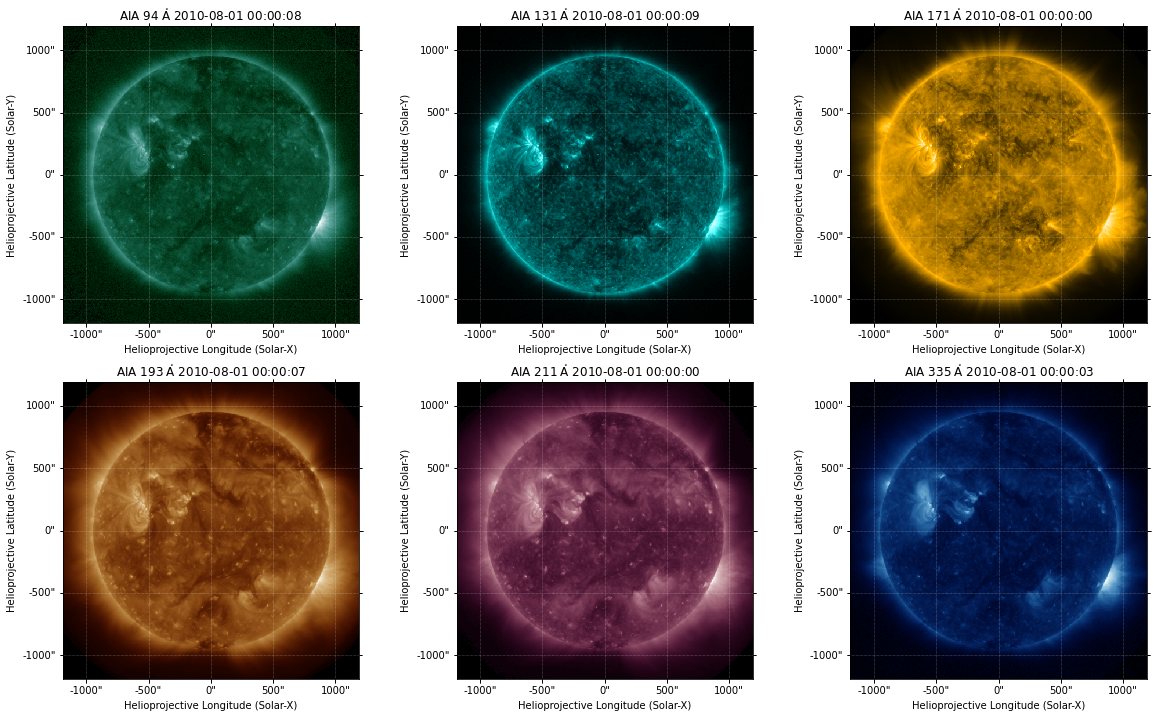

In [7]:
plt.figure(figsize=(20, 12))

i = 0
# iterate through instruments (here there is only AIA data)
for inst in data["data"]:
    # iterate through the various channels for the given batch index
    for img_index in range(data["data"][inst][0, :, 0, 0].shape[0]):
        # Create a sunpy map with the data
        selected_image = data["data"][inst][0, img_index, :, :]
        selected_headr = {
            keys: values[img_index]
            for keys, values in ast.literal_eval(data["meta"][inst][0]).items()
        }
        my_map = sunpy.map.Map(selected_image.numpy(), selected_headr)

        # set the index and plot the sunpy.map
        ax = plt.subplot(2, 3, i + 1, projection=my_map)
        my_map.plot()

        i += 1

---